In [1]:
import numpy as np
import pandas as pd
import os
import keras
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from datetime import datetime
import time
from keras.layers import Input,Convolution2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from mtcnn.mtcnn import MTCNN
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
def time_capturing():
    date_time = datetime.now().isoformat(" ")
    start_time = datetime.now()
    date_time = date_time.split(" ")
    date = date_time[0]
    date = date.replace("-"," ")
    time = date_time[1]
    return [date,time,start_time]


In [3]:
x = time_capturing()
print(x)

['2019 11 25', '15:37:01.603067', datetime.datetime(2019, 11, 25, 15, 37, 1, 603067)]


In [4]:
datetime.now()

datetime.datetime(2019, 11, 25, 9, 46, 26, 474067)

In [4]:
def collecting_data():
    count = 0
    image_data = []
    labels = []
    img_labels = {}
    file_types = ["*.jpg","*.jpeg"]
    dataset_path = Path("FLask_Practice/static/Dataset/")
    for img_dir in dataset_path.glob("*"):
        
        dir_name = img_dir
        print(str(dir_name).split("\\")[-1])
        print("Data Loaded Succefully...[/]")
        
        for file_type in file_types:
            for images in dir_name.glob(file_type):
                img_data = cv2.imread(str(images))
                img_data = cv2.resize(img_data,(100,100))
                img_data = np.asarray(img_data)
                image_data.append(img_data)
                img_labels[str(dir_name).split("\\")[-1]] = count
                labels.append(img_labels[str(dir_name).split("\\")[-1]])
        else:
            count+=1
        
    print(img_labels)
    print(labels)
    print(count,"Images Loaded Succesfully..[/]")
    image_data = np.array(image_data)
    print(image_data.shape)
    image_data = np.reshape(image_data,(image_data.shape[0],-1))
    labels = np.array(labels)
    
    return image_data,labels,img_labels
    
    

In [5]:
def organisation_data():
    
    data = pd.read_csv("Flask_Practice/static/OrganisationData/Data.csv")
    information = []
    for col in data.columns:
        if col is not None:
            information.append(list(data[col].values))
    return information
    

In [33]:
def predict(X_test):
    print(knn)
    global stored_data,labels,img_labels
    global knn
    
    pred = None
    label2name = {int(value):str(key) for (key,value) in img_labels.items()}
    try:
        X_test = np.array(X_test)
        X_test = np.reshape(X_test,(1,-1))
        pred = knn(X_test)
        return pred
    
    except Exception:
        pass
    

SyntaxError: name 'knn' is used prior to global declaration (cell_name, line 7)

In [73]:
def fetch_image(fetch_image_data,frames,arrival_time):
#     print("fetch")
    global data
    global img_labels
    global knn
    label2name = {int(value):str(key) for key,value in img_labels.items()}
    person_names = data[1]
    person_labels = [1,0,3]
#     print(label2name)
    status = 0
    vote = {'Known':[0,0],'Unknown':[0,0]}
    predicted_label = []
    for i in range(1,10):
        fetch_image_data[i] = np.reshape(fetch_image_data[i],(1,-1))
#         print(fetch_image_data[i].shape)
#         print(knn.predict(fetch_image_data[i]))
        predicted_label.append(knn.predict(fetch_image_data[i]))
#         print(predicted_label)
        if(predicted_label[-1] in person_labels):
            vote['Known'][0]+=1
            vote['Known'][1]=i
        else:
            vote['Unknown'][0]+=1
            vote['Unknown'][1]=i
            
    predicted_label = np.array(predicted_label)
    label,count = np.unique(predicted_label,return_counts = True)
    count = list(count)
    predicted_label = label[count.index(max(count))]
    predicted_label = label2name[predicted_label]
    
    if(vote['Known'][0]>vote['Unknown'][0]):
        print("Found in Organisation Database.....[/]")
        location = "Flask_Practice/static/Known_Data/Recognized.csv"
        process_data(predicted_label,frames[vote['Known'][1]],arrival_time,location)
        print("Data Saved Successfully.....[/]\n")
   
    else:
        print("Match Not Found in Organisation Database.....[/]")
        location = "Flask_Practice/static/Known_Data/Recognized.csv"
        process_data('Unknown',frames[vote['Unknown'][1]],arrival_time,location)
        print("Data Saved Successfully.....[/]\n")
    

In [53]:
x = time_capturing()
print(x)

['2019 11 25', '15:51:15.697570', datetime.datetime(2019, 11, 25, 15, 51, 15, 697570)]


In [69]:
def process_data(predicted_label,frame,arrival_time,location):
    global data
#     print("data")
    df = None
    csv_data = {'Image Name':None,'Name':None,'DOB':None,'Email':None,'Contact':None,'ArrivalTime':None,'CompletionTime':None,'Date':None,'Start':None,'End':None}
    frame = cv2.resize(frame,(400,400))
    print(predicted_label)
    if( predicted_label != "Unknown"):
        index = data[1].index(predicted_label)
        csv_data['Name'] = predicted_label
        csv_data['DOB'] = data[2][index]
        csv_data['Email'] = data[3][index]
        csv_data['Contact'] = data[4][index]
    else:
        csv_data['Name'] = predicted_label
    
    tm = time_capturing()
    csv_data['Date'] = tm[0]
    csv_data['CompletionTime'] = tm[1]
    csv_data['ArrivalTime'] = arrival_time[1]
    csv_data['Start'] = arrival_time[2]
    csv_data['End'] = tm[2]
    
    
    
    file_name = str(csv_data['Date']).replace(" ","")+"-"+"-".join(str(csv_data['ArrivalTime']).split(":"))[:8]
    csv_data['Image Name'] = file_name
    check_file = None
    print(csv_data)
    print("/".join(str(location).split("/")[:-1]))
    cv2.imwrite("/".join(str(location).split("/")[:-1])+'/Images/'+file_name+'.jpg',frame)
    
    try:
        df = pd.read_csv(location,index_col=0)
        check_file = True
        
    except Exception as e:
        check_file = False
        df = pd.DataFrame(csv_data,index = [0])
        df.to_csv(location)

    if(check_file):
        csv_data = pd.DataFrame(csv_data,index = [0])
        df = pd.concat([df, csv_data])
        df.to_csv(location)
    

In [44]:
data = organisation_data()
data


[[0, 0, 0, 0, 0],
 ['Vikash', 'Anand', 'Ravi', 'Aman', 'Vishal'],
 ['1/1/1998', '1/1/1998', '1/1/1998', '1/1/1998', '01/02/1998'],
 ['vikash@gmail.com',
  'anand@gmail.com',
  'ravi@gmail.com',
  'aman@gmail.com',
  'vishal@gmail.com'],
 [8818868818, 8728904448, 8728904445, 7722972648, 7894561235]]

In [82]:
stored_data,labels,img_labels = collecting_data()

Unknown
Data Loaded Succefully...[/]
Vikash
Data Loaded Succefully...[/]
{'Unknown': 0, 'Vikash': 1}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2 Images Loaded Succesfully..[/]
(255, 100, 100, 3)


In [89]:
# Shuffling Data
import random

combined = list(zip(stored_data,labels))

random.shuffle(combined)

stored_data, labels = zip(*combined) 

X_train = np.asarray(stored_data)
Y_train = np.asarray(labels)

In [84]:
split = int(0.8*X_train.shape[0])
X_test = X_train[split:]
X_train = X_train[:split]

Y_test = Y_train[split:]
Y_train = Y_train[:split]

In [51]:
X_test.shape

(122, 30000)

In [93]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [87]:
pred = knn.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score

In [88]:
print(accuracy_score(pred,Y_test))

0.9607843137254902


In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
# params = {
#     'n_neighbors':list(range(1,15)),
#     'weights':['uniform','distance'],
#     'metric':['euclidean','manhattan']
# }

In [57]:
# gs = GridSearchCV(knn,params,verbose = 1,cv = 4,n_jobs = -1)

In [94]:
# gs.fit(X_train,Y_train)

In [91]:
detector = MTCNN()

In [95]:
image_data = []
frames = []
offset = 5
arrival_time = []

capture = cv2.VideoCapture(0)

while True:
    ret,frame = capture.read()
    if(ret == False):
        continue
        
    frame = cv2.flip(frame,1)
    cv2.imshow("Original Frame",frame)
    result = detector.detect_faces(frame)
    original_frame = frame.copy()
    
    try:
    
        if(len(result)!=0):
            x,y,w,h = result[0]['box']
            
            cv2.imshow("frame",frame)
            keypoints = result[0]['keypoints']
            cv2.rectangle(frame,(x, y),(x+w-10, y+h-10),(0,155,255),2)
            cv2.circle(frame,(keypoints['left_eye']), 2, (0,155,255), 2)
            cv2.circle(frame,(keypoints['right_eye']), 2, (0,155,255), 2)
            cv2.circle(frame,(keypoints['nose']), 2, (0,155,255), 2)
            cv2.circle(frame,(keypoints['mouth_left']), 2, (0,155,255), 2)
            cv2.circle(frame,(keypoints['mouth_right']), 2, (0,155,255), 2)

            if(w>=50 and h>=50):
                img = frame[y-offset:y+h+offset,x-offset:x+w+offset]
                cv2.imshow("frame",img)
                img = cv2.resize(img,(100,100))
                img = np.asarray(img)
                image_data.append(img)
                frames.append(original_frame)
                
                if(len(image_data)==20):
                    fetch_image(image_data,frames,arrival_time)
                    image_data = []
                    arrival_time = []
                    frames = []
                    
                if(len(arrival_time)==0):
                    start = datetime.now()
                    arrival_time = time_capturing()
    
    except Exception:
        image_data = []
        arrival_time = []
        frames = []
    
    if(cv2.waitKey(1) & 0xFF == ord('q')):
        capture.release()
        cv2.destroyAllWindows()
        break
        

Found in Organisation Database.....[/]
Vikash
{'Image Name': '20191125-16-30-13', 'Name': 'Vikash', 'DOB': '1/1/1998', 'Email': 'vikash@gmail.com', 'Contact': 8818868818, 'ArrivalTime': '16:30:13.942098', 'CompletionTime': '16:30:19.365002', 'Date': '2019 11 25', 'Start': datetime.datetime(2019, 11, 25, 16, 30, 13, 942098), 'End': datetime.datetime(2019, 11, 25, 16, 30, 19, 365002)}
Flask_Practice/static/Known_Data
Data Saved Successfully.....[/]

Found in Organisation Database.....[/]
Vikash
{'Image Name': '20191125-16-30-19', 'Name': 'Vikash', 'DOB': '1/1/1998', 'Email': 'vikash@gmail.com', 'Contact': 8818868818, 'ArrivalTime': '16:30:19.387987', 'CompletionTime': '16:30:25.692390', 'Date': '2019 11 25', 'Start': datetime.datetime(2019, 11, 25, 16, 30, 19, 387987), 'End': datetime.datetime(2019, 11, 25, 16, 30, 25, 692390)}
Flask_Practice/static/Known_Data
Data Saved Successfully.....[/]

Found in Organisation Database.....[/]
Vikash
{'Image Name': '20191125-16-30-25', 'Name': 'Vikas

In [3]:
accuracy = []

In [25]:
accuracy.append(0.99901)

In [26]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

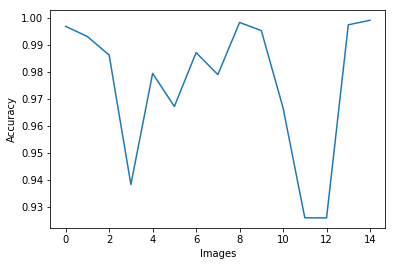

In [30]:
plt.plot(accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Images")
plt.savefig("Accuracy.png")
plt.show

In [28]:
plt.savefig("Accuracy.png")

<Figure size 432x288 with 0 Axes>

In [35]:
location = "Known_Data/Recognized.csv"

In [21]:
df = pd.read_csv("Flask_Practice/static/Known_Data/Recognized.csv")

In [75]:
capture.release()
cv2.destroyAllWindows()

In [67]:
label2name = {int(value):str(key) for key,value in img_labels.items()}

In [68]:
label2name

{0: 'Aman', 1: 'Unknown', 2: 'Vikash'}

In [69]:
capture = cv2.VideoCapture(0)
while True:
    ret,frame = capture.read()
    if(ret == False):
        continue
        
    frame = cv2.flip(frame,1)
    cv2.imshow("Original Frame",frame)
    result = detector.detect_faces(frame)
    if(len(result)!=0):
        x,y,w,h = result[0]['box']
        keypoints = result[0]['keypoints']
        cv2.rectangle(frame,(x, y),(x+w-10, y+h-10),(0,155,255),2)
       
        face_section = frame[y-offset:y+h+offset,x-offset:x+w+offset]
        face_section = cv2.resize(face_section,(100,100))
        print(np.reshape(face_section,(1,-1)).shape)
        pred = knn.predict(np.reshape(face_section,(1,-1)))
        print(label2name[pred[0]])
#         cv2.imshow(frame)
        
    if(cv2.waitKey(1) & 0xFF == ord('q')):
        capture.release()
        cv2.destroyAllWindows()
        break
    

(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Aman
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Unknown
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash
(1, 30000)
Vikash

In [48]:
count = 1
location.split("/")[0]+"/"+"%s.npy"%(count)

'Known_Data/1.npy'

In [66]:
capture.release()
cv2.destroyAllWindows()

In [57]:
def visualizing_image(location):
    
    path = Path(location+"/")
    
    for img_file in path.glob("*.npy"):
        file = np.load(str(img_file))
        image = np.reshape(file,(400,400,3))
        plt.imshow(image)
        plt.show()
    

TypeError: Image data cannot be converted to float

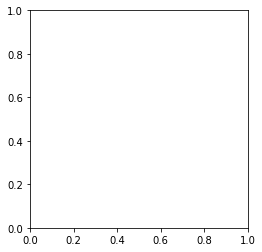

In [34]:
plt.imshow("Known_Data/Images/0.jpg")

In [16]:
capture = cv2.VideoCapture(0)

In [17]:
ret,frame = capture.read()

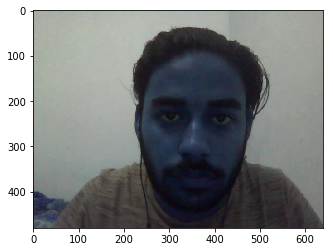

In [19]:
plt.imshow(frame)

In [20]:
cv2.imwrite("Known_Data/Images/1.jpg",frame)

True

In [18]:
capture.release()
cv2.destroyAllWindows()

Enter Location of Directory : Known_Data


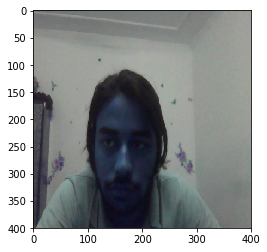

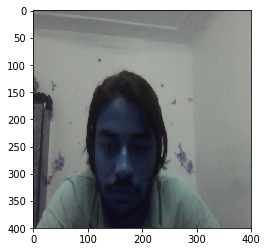

In [58]:
location = input("Enter Location of Directory : ")
visualizing_image(location)

In [60]:
def ConvertImages(location):
    
    path = Path(location+"/")
    dest_path = location+"/Images/"
    for img_file in path.glob("*.npy"):
        file = np.load(str(img_file))
        image = np.reshape(file,(400,400,3))
        cv2.imwrite(str(dest_path)+str(img_file).split("\\")[-1][:-4]+".jpg",image)
        print("Converted Successfuly.....[/]")

In [22]:
location = input("Enter Location of Directory : ")
ConvertImages(location)

Converted Successfuly.....[/]
Converted Successfuly.....[/]
Converted Successfuly.....[/]
Converted Successfuly.....[/]
Converted Successfuly.....[/]


In [66]:
d = {'c':['22 13 18','22 13 18','22 13 18']}

In [67]:
d

{'c': ['22 13 18', '22 13 18', '22 13 18']}

In [68]:
a = [str(i).replace(" ","/") for i in d['c']]

In [69]:
a

['22/13/18', '22/13/18', '22/13/18']